In [47]:
# load h5 database
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# start dark background for plots
# plt.style.use('dark_background')

In [48]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from circle_fit import taubinSVD

def sphere_fit(points):
    """
    Fit a sphere to a set of points in 3D space using the Taubin SVD method.
    :param points: Nx3 array of points
    :return: center of the sphere and radius
    """
    # convert points to numpy array
    points = np.array(points)
    # Fit a sphere to the points
    xc, yc, r, sigma = taubinSVD(points)
    return r, (xc, yc)

arena_radius = 75 # mm
arena_center = np.array([0, 0])
# trail radius
trail_radius = 42.5
trail_width = 5
trail_bounds = (trail_radius - trail_width/2, trail_radius + trail_width/2)

In [49]:
def get_segments(odor_present, max_gap):
    """
    Find segments of odor_present with a maximum gap of max_gap frames between them.

    Parameters:
    - odor_present: numpy.ndarray, boolean array indicating odor presence
    - max_gap: int, maximum gap allowed between odor detections

    Returns:
    - segments: list of tuples, where each tuple contains the start and end indices of a segment
    """
    # Get indices where odor is present
    true_indices = np.where(odor_present)[0]
    segments = []

    if true_indices.size > 0:
        start = true_indices[0]
        end = true_indices[0]
        
        # Iterate over remaining indices
        for idx in true_indices[1:]:
            if idx - end <= max_gap:
                end = idx
            else:
                segments.append((start, end))
                start = idx
                end = idx
        segments.append((start, end))
    
    return segments

def calculate_segment_movements(segments, x, y, odor_present, odor_gated=True):
    """
    Calculate total movement for each segment.

    Parameters:
    - segments: list of tuples, where each tuple contains the start and end indices of a segment
    - x: numpy.ndarray, x-coordinates of the trajectory
    - y: numpy.ndarray, y-coordinates of the trajectory
    - odor_present: numpy.ndarray, boolean array indicating odor presence
    - odor_gated: boolean, whether to gate movements by odor presence

    Returns:
    - segment_movements: list of tuples, where each tuple contains the total movement, start, and end indices of a segment
    """
    segment_movements = []
    for start, end in segments:
        dx = np.diff(x[start:end + 1])
        dy = np.diff(y[start:end + 1])
        if odor_gated:
            odor_mask = odor_present[start:end + 1]
            dx = dx[odor_mask[:-1]]
            dy = dy[odor_mask[:-1]]
        movement = np.sum(np.sqrt(dx**2 + dy**2))
        segment_movements.append((movement, start, end))
    return segment_movements

In [50]:
max_gap = 1*25

In [5]:
# load csv
filename = '-starved-1'

def hit_and_run(filename, max_gap):

    fractions = []

    # load csv
    df = pd.read_csv('tracks' + filename + '.csv')

    # Compute the convex hull of the points
    points = df[['X', 'Y']].values
    hull = ConvexHull(points)
    hull_points = []
    for simplex in hull.simplices:
        hull_points.append(points[simplex, :])
    hull_points = np.concatenate(hull_points)
    # get the center of the circle
    radius, center = sphere_fit(hull_points)

    f = h5py.File('data' + filename + '.h5', 'r')
    data = f['data']
    n_flies = data[:].shape[1]

    # get first frame and last frame with phase == stim
    start_frames = []
    end_frames = []
    for i in range(n_flies):
        fly = data[10:,i]
        phase = fly['phase']
        start_frames.append(np.where(phase == b'stim')[0][0])
        end_frames.append(np.where(phase == b'stim')[0][-1])
    start_frame = int(np.min(start_frames))
    end_frame = int(np.max(end_frames))

    points = []
    for i in range(n_flies):
        fly = data[10:,i]
        x = fly['position_x']
        y = fly['position_y']
        odor = fly['red_at_position']
        # get only x position and y position where odor is present
        x_odor = x[odor>0]
        y_odor = y[odor>0]
        points.append(np.array([x_odor, y_odor]).T)
    points = np.concatenate(points)
    # Compute the convex hull of the points
    hull = ConvexHull(points)
    # Plot the convex hull
    hull_points = []
    for simplex in hull.simplices:
        hull_points.append(points[simplex, :])
    hull_points = np.concatenate(hull_points)
    # get the center of the circle
    outer_radius, trail_center_outer = sphere_fit(hull_points)

    # get all points that are within the bounds and right after odor
    points = []
    for i in range(n_flies):
        fly = data[10:,i]
        x = fly['position_x']
        y = fly['position_y']
        odor = fly['red_at_position']
        r = np.sqrt((x-trail_center_outer[0])**2 + (y-trail_center_outer[1])**2)
        within_radius = r < outer_radius-10
        # get only x position and y position where odor is present
        x_odor = x[1:][np.logical_and(np.diff(odor)<0, within_radius[1:])]
        y_odor = y[1:][np.logical_and(np.diff(odor)<0, within_radius[1:])]
        points.append(np.array([x_odor, y_odor]).T)
    # get the convex hull of the points
    points = np.concatenate(points)
    hull = ConvexHull(points)
    hull_points = []
    for simplex in hull.simplices:
        hull_points.append(points[simplex, :])
    hull_points = np.concatenate(hull_points)
    # get the center of the circle
    inner_radius, trail_center_inner = sphere_fit(hull_points)

    # get radial distance from trail_center_inner
    df['r_inner'] = np.sqrt((df['X']-trail_center_inner[0])**2 + (df['Y']-trail_center_inner[1])**2)
    df['r_outer'] = np.sqrt((df['X']-trail_center_outer[0])**2 + (df['Y']-trail_center_outer[1])**2)

    # transform the points to the real coordinate system
    df['X'] = (df['X'] - center[0])/radius*arena_radius
    df['Y'] = (df['Y'] - center[1])/radius*arena_radius
    # get radial distance from center
    df['r'] = np.sqrt(df['X']**2 + df['Y']**2)
    # get the points that are within the bounds
    df['outside'] = df['r_outer'] > outer_radius
    df['inside'] = df['r_inner'] < inner_radius
    df['in_trail_region'] = np.logical_not(np.logical_or(df['outside'], df['inside']))

    df['during_stim'] = np.logical_and(df['FrameID'] > start_frame, df['FrameID'] < end_frame)

    df['in_odor'] = df['in_trail_region'] & df['during_stim']

    # # plot the trajectories with the odor trail
    # fig, ax = plt.subplots()
    # for fly_id in df['TargetID'].unique():
    #     fly = df[df['TargetID'] == fly_id]
    #     ax.plot(fly['X'], fly['Y'],'-',color='black',linewidth=0.5,zorder=1)
    #     ax.scatter(fly['X'][fly['in_odor']], fly['Y'][fly['in_odor']],color='red',s=0.01)
    # ax.set_aspect('equal')
    # ax.set_axis_off()


    for fly_id in df['TargetID'].unique():
        fly = df[df['TargetID'] == fly_id]
        x = fly['X'].values
        y = fly['Y'].values
        inside = fly['inside'].values
        outside = fly['outside'].values
        odor = fly['in_odor'].values
        stim_on = fly['during_stim'].values

        segments = get_segments(fly['in_odor'], max_gap)

        # get whether segment is during stim
        during_stim = []
        for start, end in segments:
            during_stim.append(np.all(stim_on[start:end + 1]))
        during_stim = np.array(during_stim)


        # get number of entries in each segment
        n_entries = []
        for start, end in segments:
            odor_seg = odor[start:end + 1]
            n_entries.append(np.sum(np.diff(np.int32(odor_seg))==1)+1)
        n_entries = np.array(n_entries)

        # get whether the sides are the same
        same_side = []
        for start, end in segments:
            start = max(0, start - 1)
            end = min(len(fly) - 1, end + 1)
            start_inside = inside[start]
            end_inside = inside[end]
            start_outside = outside[start]
            end_outside = outside[end]
            same_side.append((start_inside == end_inside) or (start_outside == end_outside))
        same_side = np.array(same_side)

        # hit and run encounters are encounter with a single entry and same side exit
        hit_and_run = (n_entries == 1) & same_side & during_stim
        n_hit_and_run = np.sum(hit_and_run)
        n_during_stim = np.sum(during_stim)
        print("Fraction of hit and run encounters: %f" % (n_hit_and_run / n_during_stim))
        fractions.append(n_hit_and_run / n_during_stim)
        
    return fractions

hit_and_run(filename, max_gap)


Fraction of hit and run encounters: 0.104575
Fraction of hit and run encounters: 0.096774
Fraction of hit and run encounters: 0.125000
Fraction of hit and run encounters: 0.137255


[np.float64(0.10457516339869281),
 np.float64(0.0967741935483871),
 np.float64(0.125),
 np.float64(0.13725490196078433)]

In [6]:
max_gap = 1*25
s1 = hit_and_run('-starved-1', max_gap)
s2 = hit_and_run('-starved-2', max_gap)
a1 = hit_and_run('-ablated-l', max_gap)
a2 = hit_and_run('-ablated-r', max_gap)

Fraction of hit and run encounters: 0.104575
Fraction of hit and run encounters: 0.096774
Fraction of hit and run encounters: 0.125000
Fraction of hit and run encounters: 0.137255
Fraction of hit and run encounters: 0.187500
Fraction of hit and run encounters: 0.115385
Fraction of hit and run encounters: 0.225806
Fraction of hit and run encounters: 0.210526
Fraction of hit and run encounters: 0.200000
Fraction of hit and run encounters: 0.141026
Fraction of hit and run encounters: 0.166667
Fraction of hit and run encounters: 0.122449
Fraction of hit and run encounters: 0.250000
Fraction of hit and run encounters: 0.142857
Fraction of hit and run encounters: 0.238095
Fraction of hit and run encounters: 0.241379


t-statistic:  48.0
p-value:  0.10489510489510488
Effect size:  0.037456417110812046


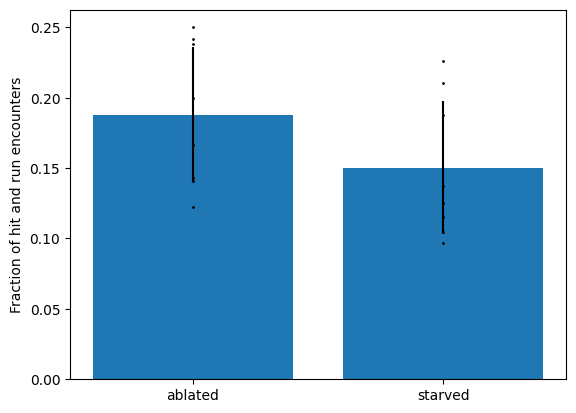

In [18]:
starved = np.concatenate([s1, s2])
ablated = np.concatenate([a1, a2])
plt.bar(['ablated', 'starved'], [np.mean(ablated), np.mean(starved)], yerr=[np.std(ablated), np.std(starved)])
# plot raw data
plt.scatter(['ablated']*len(ablated), ablated, color='black', s=1)
plt.scatter(['starved']*len(starved), starved, color='black', s=1)
# perform statistical test (mann-whitney u test)
from scipy.stats import mannwhitneyu, wilcoxon
t_stat, p_val = mannwhitneyu(ablated, starved)
print("t-statistic: ", t_stat)
print("p-value: ", p_val)
# get effect size
from statsmodels.stats.weightstats import DescrStatsW
ablated_stats = DescrStatsW(ablated)
starved_stats = DescrStatsW(starved)
effect_size = ablated_stats.mean - starved_stats.mean
print("Effect size: ", effect_size)

plt.ylabel('Fraction of hit and run encounters')
plt.show()

Pre-compiling numba functions for DABEST...


Compiling numba functions: 100%|██████████| 11/11 [00:04<00:00,  2.35it/s]


Numba compilation complete!


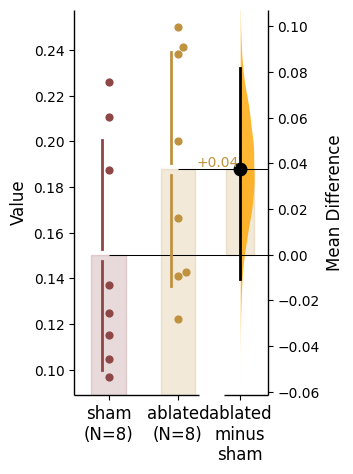

In [19]:
# estimation plot
import dabest

# convert into dataframe
hit_and_run_df = pd.DataFrame({'ablated': ablated, 'sham': starved})

dabest_obj = dabest.load(hit_and_run_df, idx=("sham", "ablated"))
fig, ax = plt.subplots(figsize=(2.5, 5))
dabest_obj.mean_diff.plot(ax=ax, custom_palette=['firebrick', 'orange'])
plt.savefig('hit_and_run.pdf', bbox_inches='tight')
plt.show()

In [27]:
filename = '-starved-1'

def reentries(filename, max_gap):

    reentries = []

    # load csv
    df = pd.read_csv('tracks' + filename + '.csv')

    # Compute the convex hull of the points
    points = df[['X', 'Y']].values
    hull = ConvexHull(points)
    hull_points = []
    for simplex in hull.simplices:
        hull_points.append(points[simplex, :])
    hull_points = np.concatenate(hull_points)
    # get the center of the circle
    radius, center = sphere_fit(hull_points)

    f = h5py.File('data' + filename + '.h5', 'r')
    data = f['data']
    n_flies = data[:].shape[1]

    # get first frame and last frame with phase == stim
    start_frames = []
    end_frames = []
    for i in range(n_flies):
        fly = data[10:,i]
        phase = fly['phase']
        start_frames.append(np.where(phase == b'stim')[0][0])
        end_frames.append(np.where(phase == b'stim')[0][-1])
    start_frame = int(np.min(start_frames))
    end_frame = int(np.max(end_frames))

    points = []
    for i in range(n_flies):
        fly = data[10:,i]
        x = fly['position_x']
        y = fly['position_y']
        odor = fly['red_at_position']
        # get only x position and y position where odor is present
        x_odor = x[odor>0]
        y_odor = y[odor>0]
        points.append(np.array([x_odor, y_odor]).T)
    points = np.concatenate(points)
    # Compute the convex hull of the points
    hull = ConvexHull(points)
    # Plot the convex hull
    hull_points = []
    for simplex in hull.simplices:
        hull_points.append(points[simplex, :])
    hull_points = np.concatenate(hull_points)
    # get the center of the circle
    outer_radius, trail_center_outer = sphere_fit(hull_points)

    # get all points that are within the bounds and right after odor
    points = []
    for i in range(n_flies):
        fly = data[10:,i]
        x = fly['position_x']
        y = fly['position_y']
        odor = fly['red_at_position']
        r = np.sqrt((x-trail_center_outer[0])**2 + (y-trail_center_outer[1])**2)
        within_radius = r < outer_radius-10
        # get only x position and y position where odor is present
        x_odor = x[1:][np.logical_and(np.diff(odor)<0, within_radius[1:])]
        y_odor = y[1:][np.logical_and(np.diff(odor)<0, within_radius[1:])]
        points.append(np.array([x_odor, y_odor]).T)
    # get the convex hull of the points
    points = np.concatenate(points)
    hull = ConvexHull(points)
    hull_points = []
    for simplex in hull.simplices:
        hull_points.append(points[simplex, :])
    hull_points = np.concatenate(hull_points)
    # get the center of the circle
    inner_radius, trail_center_inner = sphere_fit(hull_points)

    # get radial distance from trail_center_inner
    df['r_inner'] = np.sqrt((df['X']-trail_center_inner[0])**2 + (df['Y']-trail_center_inner[1])**2)
    df['r_outer'] = np.sqrt((df['X']-trail_center_outer[0])**2 + (df['Y']-trail_center_outer[1])**2)

    # transform the points to the real coordinate system
    df['X'] = (df['X'] - center[0])/radius*arena_radius
    df['Y'] = (df['Y'] - center[1])/radius*arena_radius
    # get radial distance from center
    df['r'] = np.sqrt(df['X']**2 + df['Y']**2)
    # get the points that are within the bounds
    df['outside'] = df['r_outer'] > outer_radius
    df['inside'] = df['r_inner'] < inner_radius
    df['in_trail_region'] = np.logical_not(np.logical_or(df['outside'], df['inside']))

    df['during_stim'] = np.logical_and(df['FrameID'] > start_frame, df['FrameID'] < end_frame)

    df['in_odor'] = df['in_trail_region'] & df['during_stim']

    # # plot the trajectories with the odor trail
    # fig, ax = plt.subplots()
    # for fly_id in df['TargetID'].unique():
    #     fly = df[df['TargetID'] == fly_id]
    #     ax.plot(fly['X'], fly['Y'],'-',color='black',linewidth=0.5,zorder=1)
    #     ax.scatter(fly['X'][fly['in_odor']], fly['Y'][fly['in_odor']],color='red',s=0.01)
    # ax.set_aspect('equal')
    # ax.set_axis_off()


    for fly_id in df['TargetID'].unique():
        fly = df[df['TargetID'] == fly_id]
        x = fly['X'].values
        y = fly['Y'].values
        inside = fly['inside'].values
        outside = fly['outside'].values
        odor = fly['in_odor'].values
        stim_on = fly['during_stim'].values

        segments = get_segments(fly['in_odor'], max_gap)

        # get whether segment is during stim
        during_stim = []
        for start, end in segments:
            during_stim.append(np.all(stim_on[start:end + 1]))
        during_stim = np.array(during_stim)


        # get number of entries in each segment
        n_entries = []
        for start, end in segments:
            odor_seg = odor[start:end + 1]
            n_entries.append(np.sum(np.diff(np.int32(odor_seg))==1)+1)
        n_entries = np.array(n_entries)

        # get number of entries that start on the outer side
        n_outer_entries = []
        for start, end in segments:
            start = max(0, start - 1)
            end = min(len(fly) - 1, end + 1)
            odor_seg = odor[start:end + 1]
            outside_seg = outside[start:end + 1]
            re_entry = np.where(np.diff(np.int32(odor_seg))==1)[0]
            count = 0
            # find how many of the re-entries start on the outside
            for re in re_entry:
                if outside_seg[re-1] and not outside_seg[re]:
                    count += 1
            n_outer_entries.append(count)
        n_outer_entries = np.array(n_outer_entries)

        # get number of entries that start on the outer side and are during stim
        n_outer_entries = n_outer_entries[during_stim]

        reentries.append(np.mean(n_outer_entries))
        
    return reentries

reentries(filename, max_gap)


[np.float64(0.3006535947712418),
 np.float64(0.3548387096774194),
 np.float64(0.375),
 np.float64(0.3137254901960784)]

In [28]:
max_gap = 1*25
s1 = reentries('-starved-1', max_gap)
s2 = reentries('-starved-2', max_gap)
a1 = reentries('-ablated-l', max_gap)
a2 = reentries('-ablated-r', max_gap)

t-statistic:  26.0
p-value:  0.5623719669710694
Effect size:  -0.04726247063818978


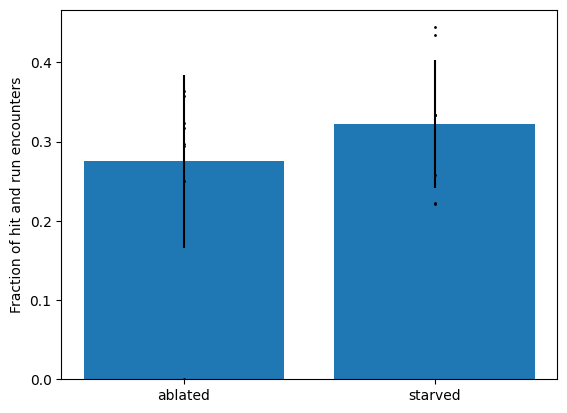

In [35]:
starved = np.concatenate([s1, s2])
ablated = np.concatenate([a1, a2])
plt.bar(['ablated', 'starved'], [np.mean(ablated), np.mean(starved)], yerr=[np.std(ablated), np.std(starved)])
# plot raw data
plt.scatter(['ablated']*len(ablated), ablated, color='black', s=1)
plt.scatter(['starved']*len(starved), starved, color='black', s=1)
# perform statistical test (mann-whitney u test)
from scipy.stats import mannwhitneyu, wilcoxon
t_stat, p_val = mannwhitneyu(ablated, starved)
print("t-statistic: ", t_stat)
print("p-value: ", p_val)
# get effect size
from statsmodels.stats.weightstats import DescrStatsW
ablated_stats = DescrStatsW(ablated)
starved_stats = DescrStatsW(starved)
effect_size = ablated_stats.mean - starved_stats.mean
print("Effect size: ", effect_size)

plt.ylabel('Fraction of hit and run encounters')
plt.show()

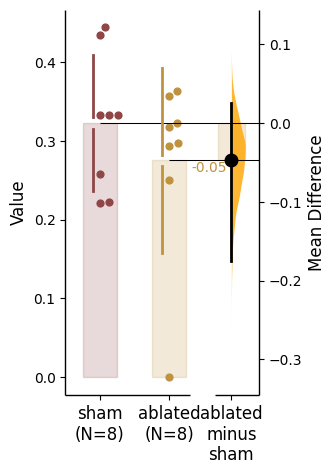

In [36]:
# estimation plot
import dabest

# convert into dataframe
hit_and_run_df = pd.DataFrame({'ablated': ablated, 'sham': starved})

dabest_obj = dabest.load(hit_and_run_df, idx=("sham", "ablated"))
fig, ax = plt.subplots(figsize=(2.5, 5))
dabest_obj.mean_diff.plot(ax=ax, custom_palette=['firebrick', 'orange'])
# plt.savefig('hit_and_run.pdf', bbox_inches='tight')
plt.show()

In [37]:
filename = '-starved-1'

def time_spent_in_odor(filename, max_gap):

    time_in_odor = []

    # load csv
    df = pd.read_csv('tracks' + filename + '.csv')

    # Compute the convex hull of the points
    points = df[['X', 'Y']].values
    hull = ConvexHull(points)
    hull_points = []
    for simplex in hull.simplices:
        hull_points.append(points[simplex, :])
    hull_points = np.concatenate(hull_points)
    # get the center of the circle
    radius, center = sphere_fit(hull_points)

    f = h5py.File('data' + filename + '.h5', 'r')
    data = f['data']
    n_flies = data[:].shape[1]

    # get first frame and last frame with phase == stim
    start_frames = []
    end_frames = []
    for i in range(n_flies):
        fly = data[10:,i]
        phase = fly['phase']
        start_frames.append(np.where(phase == b'stim')[0][0])
        end_frames.append(np.where(phase == b'stim')[0][-1])
    start_frame = int(np.min(start_frames))
    end_frame = int(np.max(end_frames))

    points = []
    for i in range(n_flies):
        fly = data[10:,i]
        x = fly['position_x']
        y = fly['position_y']
        odor = fly['red_at_position']
        # get only x position and y position where odor is present
        x_odor = x[odor>0]
        y_odor = y[odor>0]
        points.append(np.array([x_odor, y_odor]).T)
    points = np.concatenate(points)
    # Compute the convex hull of the points
    hull = ConvexHull(points)
    # Plot the convex hull
    hull_points = []
    for simplex in hull.simplices:
        hull_points.append(points[simplex, :])
    hull_points = np.concatenate(hull_points)
    # get the center of the circle
    outer_radius, trail_center_outer = sphere_fit(hull_points)

    # get all points that are within the bounds and right after odor
    points = []
    for i in range(n_flies):
        fly = data[10:,i]
        x = fly['position_x']
        y = fly['position_y']
        odor = fly['red_at_position']
        r = np.sqrt((x-trail_center_outer[0])**2 + (y-trail_center_outer[1])**2)
        within_radius = r < outer_radius-10
        # get only x position and y position where odor is present
        x_odor = x[1:][np.logical_and(np.diff(odor)<0, within_radius[1:])]
        y_odor = y[1:][np.logical_and(np.diff(odor)<0, within_radius[1:])]
        points.append(np.array([x_odor, y_odor]).T)
    # get the convex hull of the points
    points = np.concatenate(points)
    hull = ConvexHull(points)
    hull_points = []
    for simplex in hull.simplices:
        hull_points.append(points[simplex, :])
    hull_points = np.concatenate(hull_points)
    # get the center of the circle
    inner_radius, trail_center_inner = sphere_fit(hull_points)

    # get radial distance from trail_center_inner
    df['r_inner'] = np.sqrt((df['X']-trail_center_inner[0])**2 + (df['Y']-trail_center_inner[1])**2)
    df['r_outer'] = np.sqrt((df['X']-trail_center_outer[0])**2 + (df['Y']-trail_center_outer[1])**2)

    # transform the points to the real coordinate system
    df['X'] = (df['X'] - center[0])/radius*arena_radius
    df['Y'] = (df['Y'] - center[1])/radius*arena_radius
    # get radial distance from center
    df['r'] = np.sqrt(df['X']**2 + df['Y']**2)
    # get the points that are within the bounds
    df['outside'] = df['r_outer'] > outer_radius
    df['inside'] = df['r_inner'] < inner_radius
    df['in_trail_region'] = np.logical_not(np.logical_or(df['outside'], df['inside']))

    df['during_stim'] = np.logical_and(df['FrameID'] > start_frame, df['FrameID'] < end_frame)

    df['in_odor'] = df['in_trail_region'] & df['during_stim']

    # # plot the trajectories with the odor trail
    # fig, ax = plt.subplots()
    # for fly_id in df['TargetID'].unique():
    #     fly = df[df['TargetID'] == fly_id]
    #     ax.plot(fly['X'], fly['Y'],'-',color='black',linewidth=0.5,zorder=1)
    #     ax.scatter(fly['X'][fly['in_odor']], fly['Y'][fly['in_odor']],color='red',s=0.01)
    # ax.set_aspect('equal')
    # ax.set_axis_off()


    for fly_id in df['TargetID'].unique():
        fly = df[df['TargetID'] == fly_id]
        x = fly['X'].values
        y = fly['Y'].values
        inside = fly['inside'].values
        outside = fly['outside'].values
        odor = fly['in_odor'].values
        stim_on = fly['during_stim'].values

        segments = get_segments(fly['in_odor'], max_gap)

        # get whether segment is during stim
        during_stim = []
        for start, end in segments:
            during_stim.append(np.all(stim_on[start:end + 1]))
        during_stim = np.array(during_stim)


        # get fraction of time spent in odor
        time_spent = []
        for start, end in segments:
            odor_seg = odor[start:end + 1]
            time_spent.append(np.sum(odor_seg))
        time_spent = np.array(time_spent)

        # get time spent in odor during stim
        time_spent = time_spent[during_stim]
        time_in_odor.append(np.mean(time_spent))
        
    return time_in_odor

time_spent_in_odor(filename, max_gap)


[np.float64(84.32558139534883),
 np.float64(77.79166666666667),
 np.float64(119.33333333333333),
 np.float64(83.0)]

In [38]:
max_gap = 3*25
s1 = time_spent_in_odor('-starved-1', max_gap)
s2 = time_spent_in_odor('-starved-2', max_gap)
a1 = time_spent_in_odor('-ablated-l', max_gap)
a2 = time_spent_in_odor('-ablated-r', max_gap)

t-statistic:  46.0
p-value:  0.1605283605283605
Effect size:  20.725361092250296


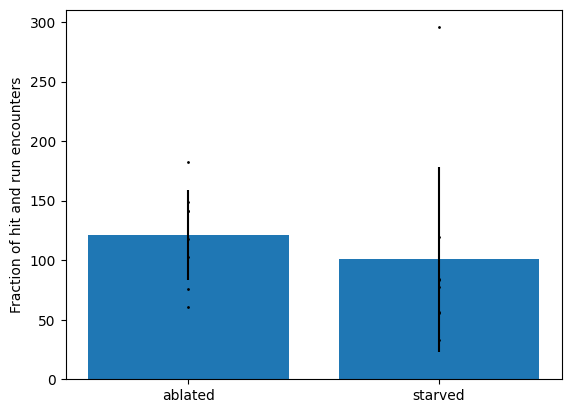

In [39]:
starved = np.concatenate([s1, s2])
ablated = np.concatenate([a1, a2])
plt.bar(['ablated', 'starved'], [np.mean(ablated), np.mean(starved)], yerr=[np.std(ablated), np.std(starved)])
# plot raw data
plt.scatter(['ablated']*len(ablated), ablated, color='black', s=1)
plt.scatter(['starved']*len(starved), starved, color='black', s=1)
# perform statistical test (mann-whitney u test)
from scipy.stats import mannwhitneyu, wilcoxon
t_stat, p_val = mannwhitneyu(ablated, starved)
print("t-statistic: ", t_stat)
print("p-value: ", p_val)
# get effect size
from statsmodels.stats.weightstats import DescrStatsW
ablated_stats = DescrStatsW(ablated)
starved_stats = DescrStatsW(starved)
effect_size = ablated_stats.mean - starved_stats.mean
print("Effect size: ", effect_size)

plt.ylabel('Fraction of hit and run encounters')
plt.show()

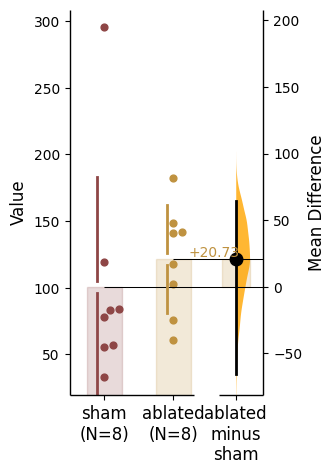

In [40]:
# estimation plot
import dabest

# convert into dataframe
hit_and_run_df = pd.DataFrame({'ablated': ablated, 'sham': starved})

dabest_obj = dabest.load(hit_and_run_df, idx=("sham", "ablated"))
fig, ax = plt.subplots(figsize=(2.5, 5))
dabest_obj.mean_diff.plot(ax=ax, custom_palette=['firebrick', 'orange'])
# plt.savefig('hit_and_run.pdf', bbox_inches='tight')
plt.show()

Keys: <KeysViewHDF5 ['data', 'metadata']>
Length of data: 71880
Length of metadata: 71880
Number of flies: 4
fly 0
total movement: 170917.389465
fraction of time in odor: 0.077571
fraction of movement in odor: 0.065123
fraction of time engaged: 0.262251
mean engagement bout length: 554.352941
fly 1
total movement: 150515.990878
fraction of time in odor: 0.021386
fraction of movement in odor: 0.026016
fraction of time engaged: 0.167038
mean engagement bout length: 400.166667
fly 2
total movement: 101487.618430
fraction of time in odor: 0.018172
fraction of movement in odor: 0.033352
fraction of time engaged: 0.182774
mean engagement bout length: 486.518519
fly 3
total movement: 190741.822108
fraction of time in odor: 0.006540
fraction of movement in odor: 0.012280
fraction of time engaged: 0.222346
mean engagement bout length: 499.375000


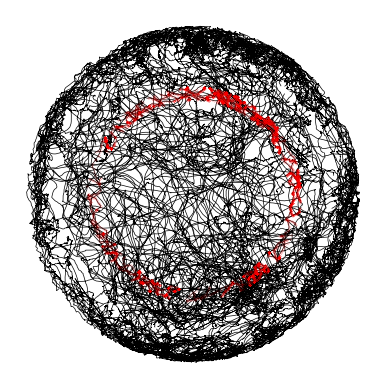

In [41]:
filename = 'data-starved-2.h5'
f = h5py.File(filename, 'r')

# List all groups
print("Keys: %s" % f.keys())

data = f['data']
metadata = f['metadata']

# compare the length of the data and metadata
print("Length of data: %d" % len(data))
print("Length of metadata: %d" % len(metadata))

# get the average frame rate
fps = 1/np.diff(metadata['timestamp']).mean()

n_flies = n_flies = data[:].shape[1]
print("Number of flies: %d" % n_flies)
fig, ax = plt.subplots(1,1)

additional_frames = 30 # frames

all_bouts = []
for i in range(n_flies):
    fly = data[10:,i]
    movement = np.sqrt(np.diff(fly['position_x'])**2 + np.diff(fly['position_y'])**2)
    movement = np.insert(movement, 0, 0)
    total_movement = np.nansum(movement)
    movement_in_odor = np.nansum(movement[fly['red_at_position']>0])
    engagement = fly['intask']
    engagement_start = np.where(np.diff(engagement)==1)[0]
    len_engagement_bouts = []
    bouts = []
    for j in engagement_start:
        # verify that engagement is 1
        if engagement[j+1]==1:
            bout = np.where(engagement[j+1:]==0)[0]
            len_engagement_bouts.append(bout[0] if len(bout)>0 else len(engagement)-j-1)
            start = max(0, j-additional_frames)
            end = min(len(engagement), j+len_engagement_bouts[-1]+additional_frames)
            # get the position and odor and save it in bouts
            bouts.append({
                'position_x': fly['position_x'][start:end],
                'position_y': fly['position_y'][start:end],
                'odor': fly['red_at_position'][start:end],
                'movement': movement[start:end],
            })
    all_bouts.extend(bouts)
    print("fly %d" % i)
    print("total movement: %f" % total_movement)
    print("fraction of time in odor: %f" % (fly['red_at_position']>0).mean())
    print("fraction of movement in odor: %f" % (movement_in_odor/total_movement))
    print("fraction of time engaged: %f" % (engagement>0).mean())
    print("mean engagement bout length: %f" % np.mean(len_engagement_bouts))
    ax.plot(fly['position_x'][:],fly['position_y'][:],'-',color='black',linewidth=0.5,zorder=1)
    # scatter plot of points where inodor is 1
    ax.scatter(fly['position_x'][fly['red_at_position']>0],fly['position_y'][fly['red_at_position']>0],color='red',s=0.01,zorder=2)
ax.set_aspect('equal', adjustable='box')
ax.set_axis_off()
plt.show()

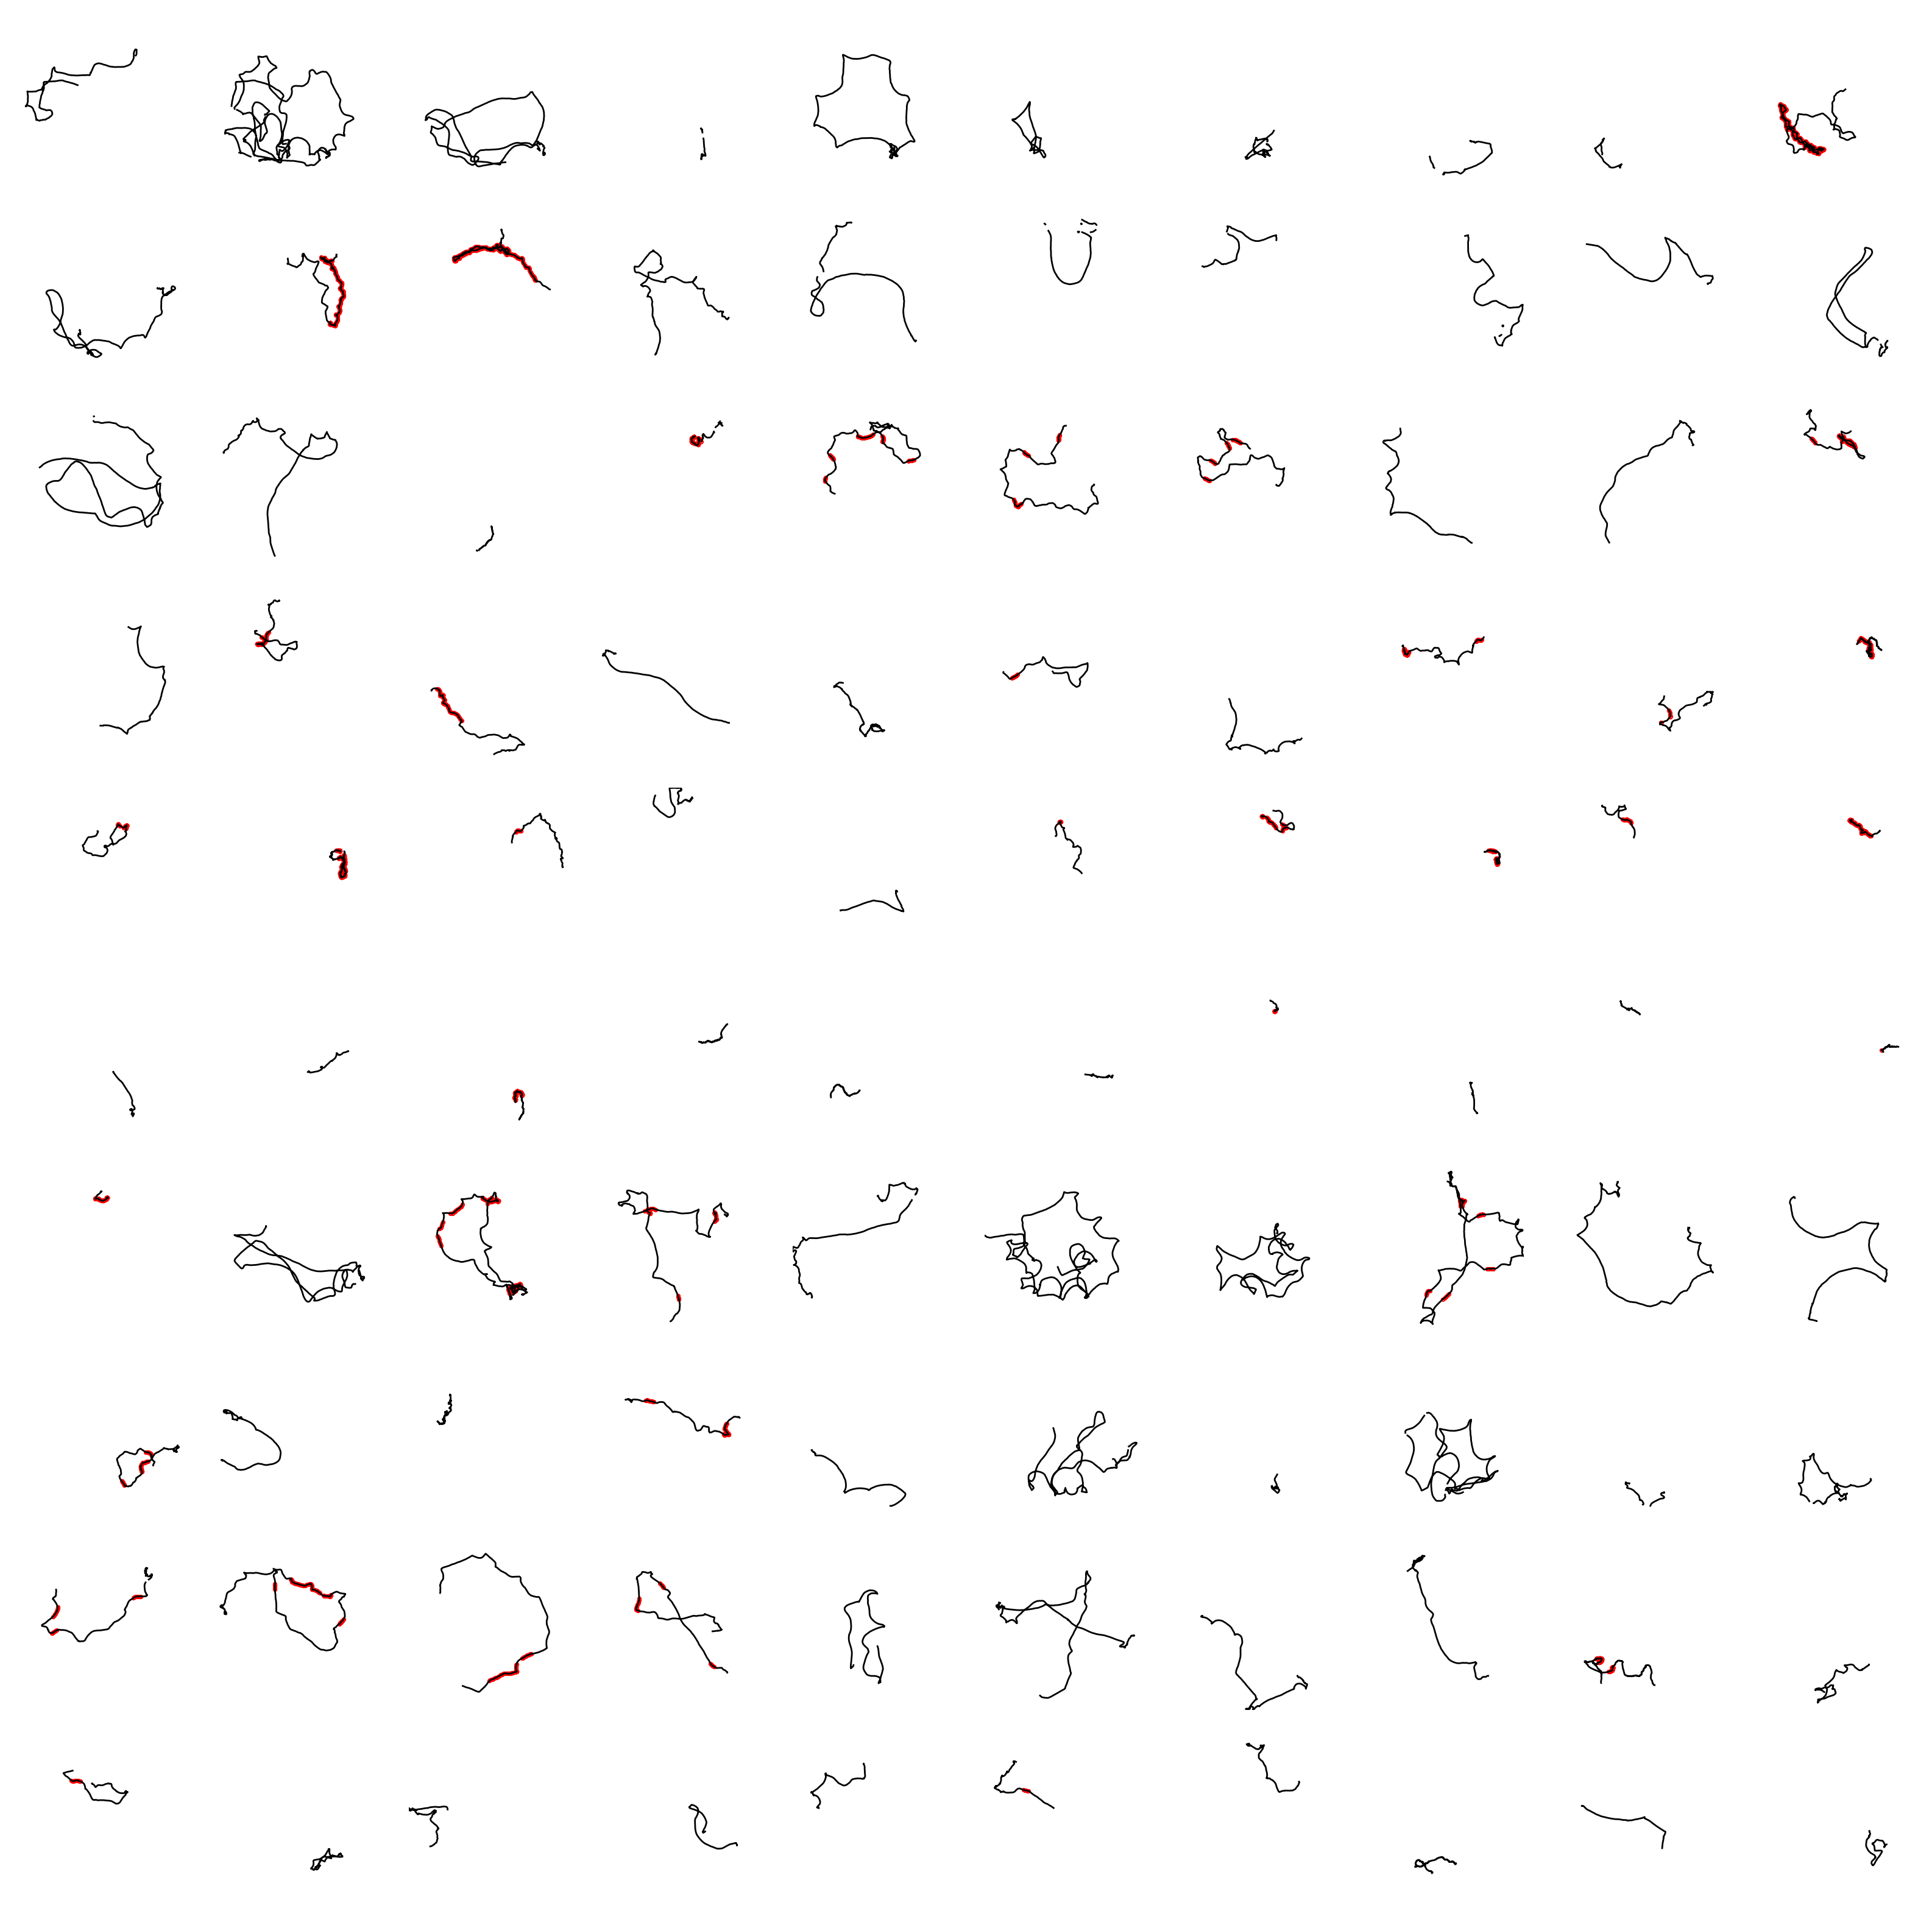

In [42]:
# sort bouts by amount of time in odor
bouts = sorted(all_bouts, key=lambda x: np.sum(x['movement']), reverse=True)
# get the x,y limits across all bouts ignoring infinite values
x_min = min([np.min(bout['position_x']) for bout in bouts if np.isfinite(np.min(bout['position_x']))])
x_max = max([np.max(bout['position_x']) for bout in bouts if np.isfinite(np.max(bout['position_x']))])
y_min = min([np.min(bout['position_y']) for bout in bouts if np.isfinite(np.min(bout['position_y']))])
y_max = max([np.max(bout['position_y']) for bout in bouts if np.isfinite(np.max(bout['position_y']))])

# plot the first 25 bouts
fig, ax = plt.subplots(10,10,figsize=(10,10),dpi=400)
for i in range(100):

    ax.flatten()[i].plot(bouts[i]['position_x'],bouts[i]['position_y'],'-',color='black',linewidth=0.5)
    ax.flatten()[i].scatter(bouts[i]['position_x'][bouts[i]['odor']>0],bouts[i]['position_y'][bouts[i]['odor']>0],color='red',s=0.1)
    ax.flatten()[i].set_xlim(x_min,x_max)
    ax.flatten()[i].set_ylim(y_min,y_max)
    ax.flatten()[i].set_aspect('equal', adjustable='box')
    ax.flatten()[i].set_axis_off()
plt.savefig('bouts.pdf', dpi=400)
plt.show()


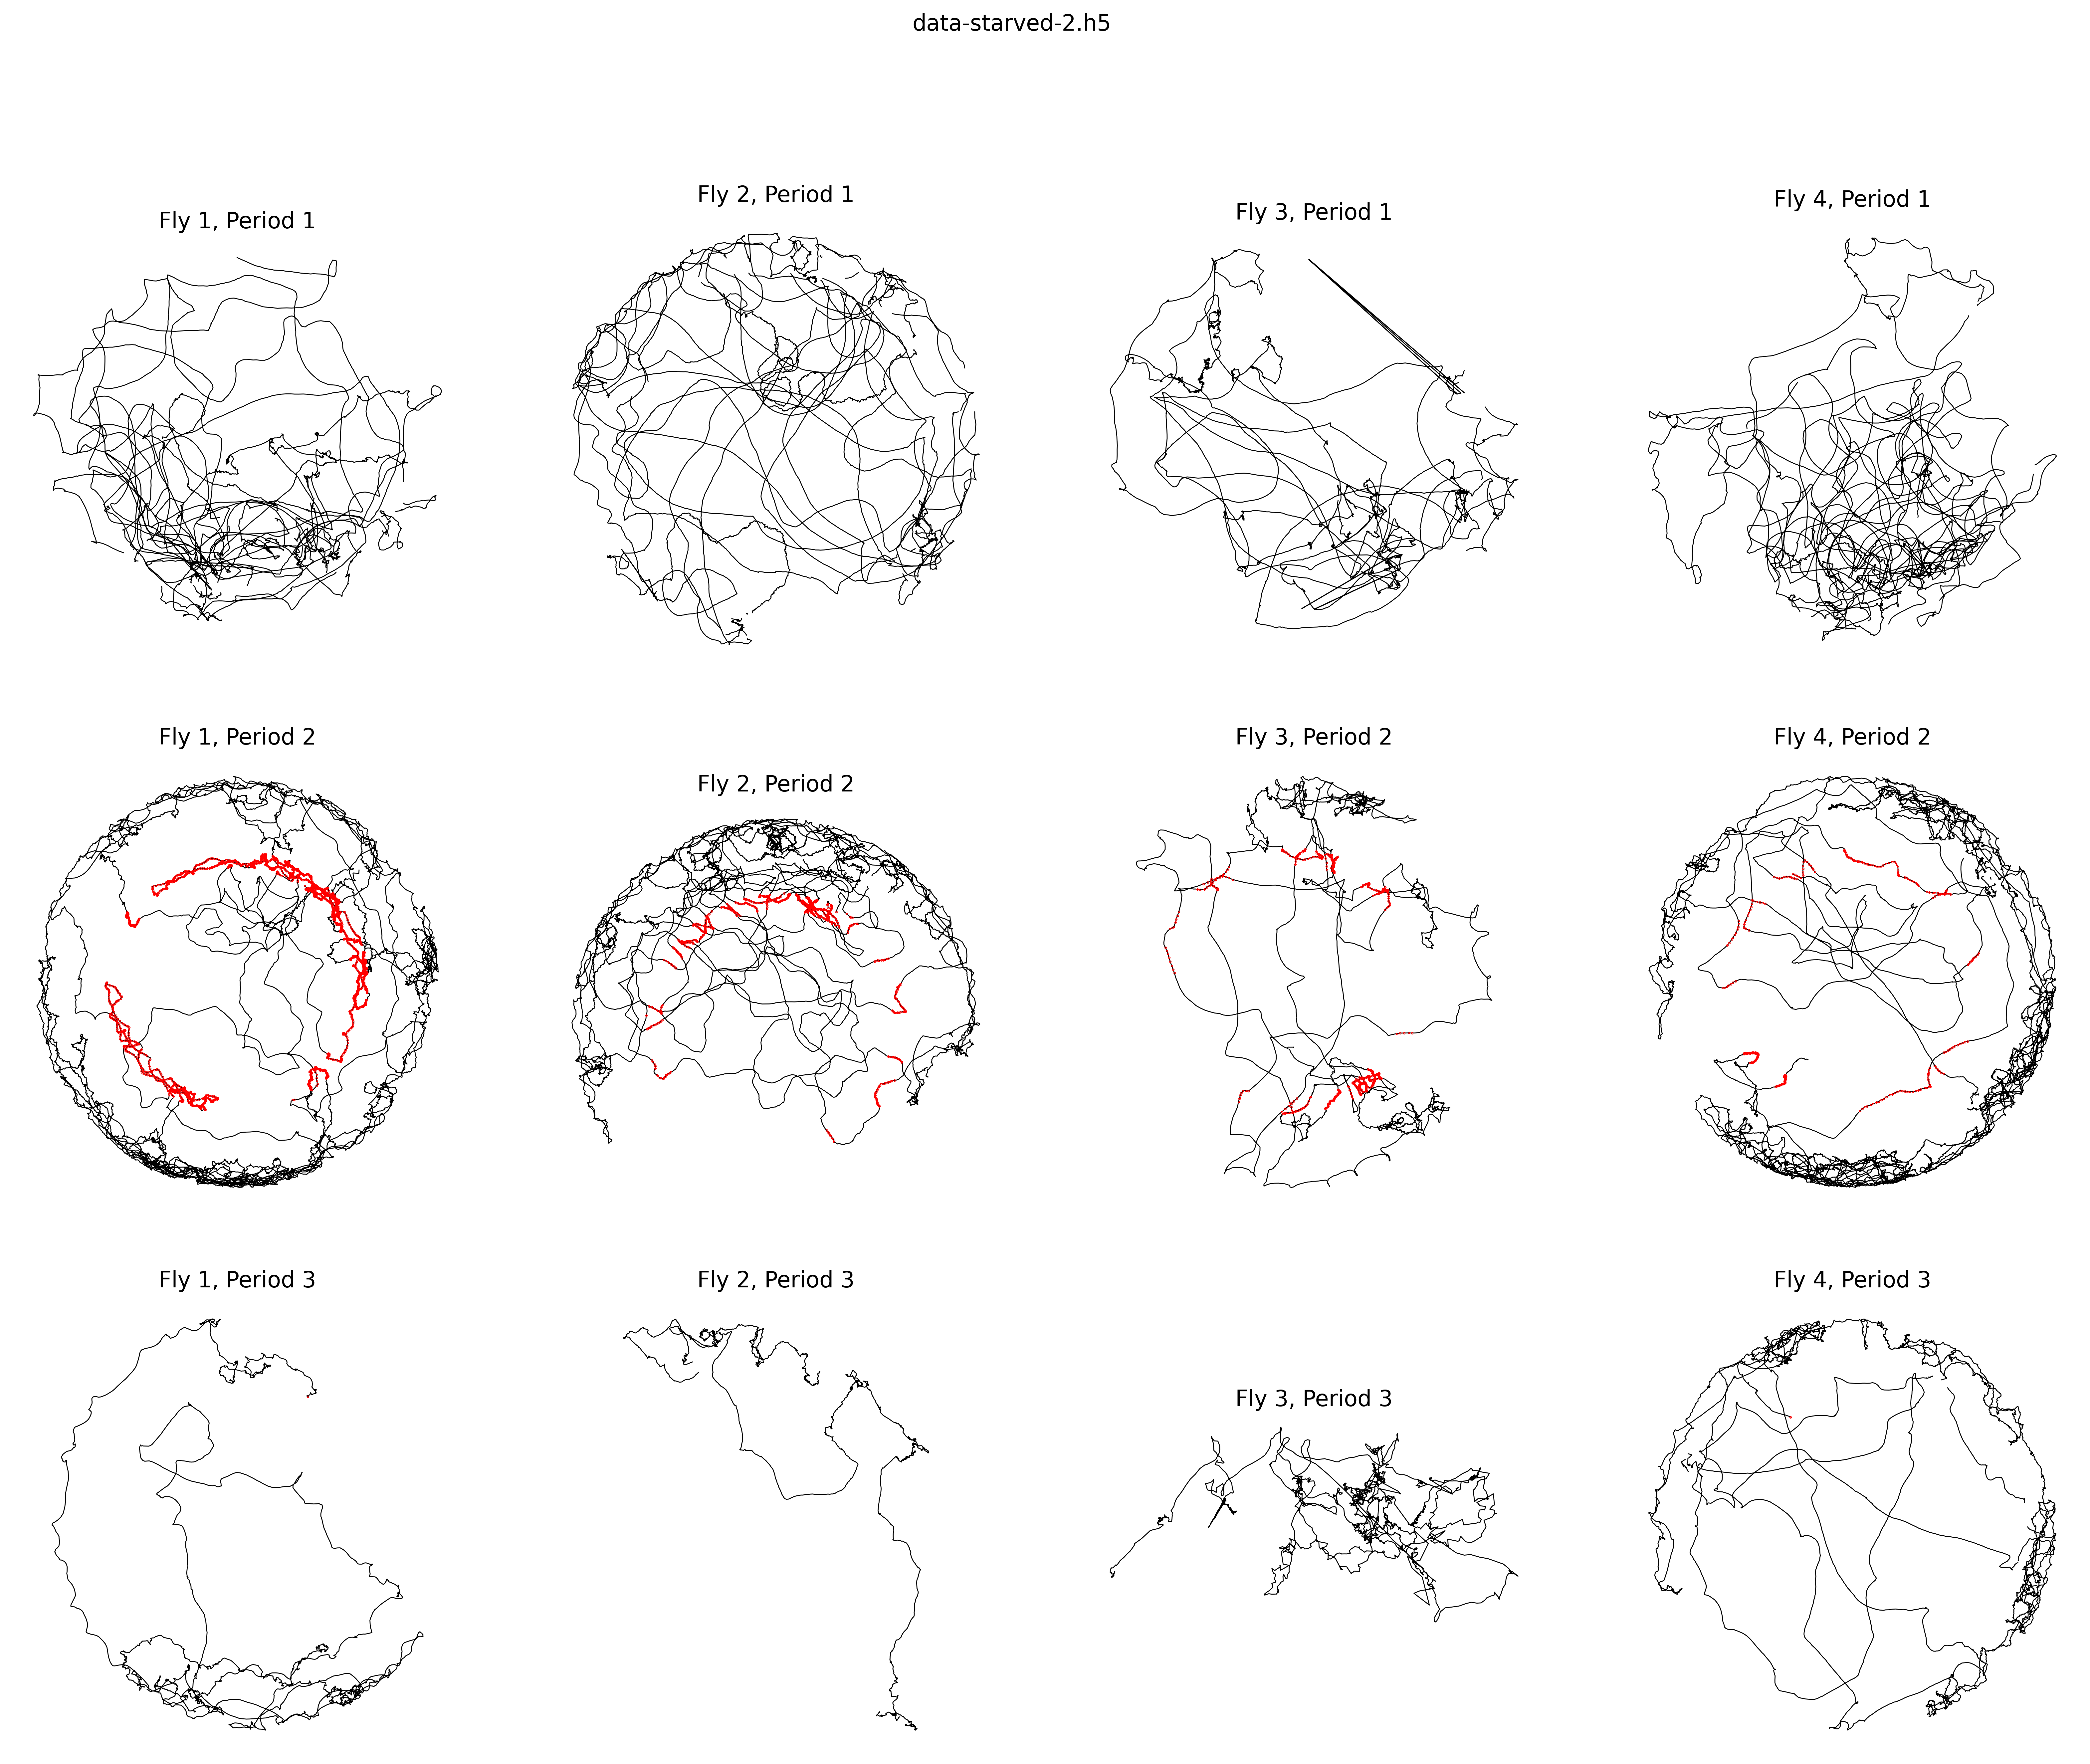

In [43]:
periods = [
    (0, 15*60),  # first 60 min
    (15*60, 45*60),  # second 60 min
    (45*60, None),  # last 60 min
]
time = metadata['timestamp'] - metadata['timestamp'][0]  # normalize the timestamp to start from 0

fig, ax = plt.subplots(len(periods),n_flies,figsize=(5*n_flies,5*len(periods)),dpi=400)

for i in range(n_flies):
    fly = data[:,i]
    for n,period in enumerate(periods):
        time_mask = (time >= period[0]) & (time < (period[1] if period[1] is not None else time[-1]))
        ax[n,i].plot(fly['position_x'][time_mask],fly['position_y'][time_mask],'-',color='black',linewidth=0.5,zorder=1)
        # scatter plot of points where inodor is 1
        ax[n,i].scatter(fly['position_x'][time_mask & (fly['red_at_position']>0)],fly['position_y'][time_mask & (fly['red_at_position']>0)],color='red',s=0.1,zorder=2)
        ax[n,i].set_aspect('equal', adjustable='box')
        ax[n,i].set_axis_off()
        ax[n,i].set_title(f'Fly {i+1}, Period {n+1}')
plt.suptitle(filename)
plt.show()

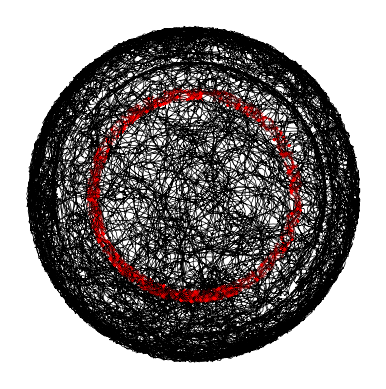

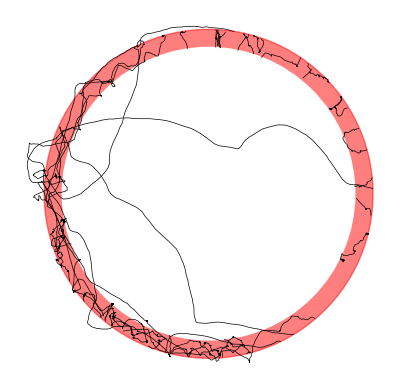

Fraction of hit and run encounters: 0.081081


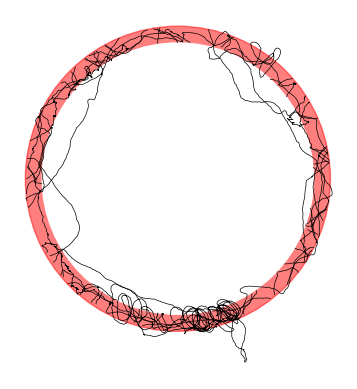

Fraction of hit and run encounters: 0.123077


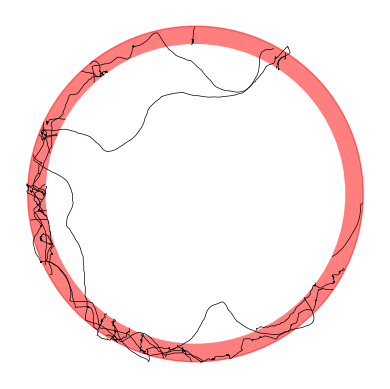

Fraction of hit and run encounters: 0.071429


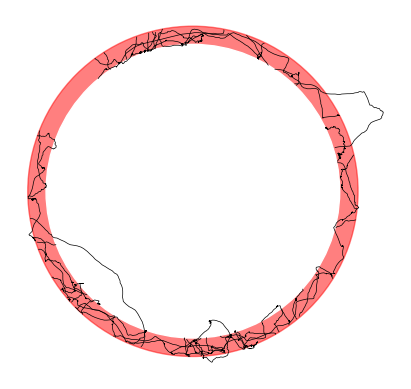

Fraction of hit and run encounters: 0.121951


In [46]:
# load csv
filename = '-ablated-l'

fractions = []

# load csv
df = pd.read_csv('tracks' + filename + '.csv')

# Compute the convex hull of the points
points = df[['X', 'Y']].values
hull = ConvexHull(points)
hull_points = []
for simplex in hull.simplices:
    hull_points.append(points[simplex, :])
hull_points = np.concatenate(hull_points)
# get the center of the circle
radius, center = sphere_fit(hull_points)

f = h5py.File('data' + filename + '.h5', 'r')
data = f['data']
n_flies = data[:].shape[1]

# get first frame and last frame with phase == stim
start_frames = []
end_frames = []
for i in range(n_flies):
    fly = data[10:,i]
    phase = fly['phase']
    start_frames.append(np.where(phase == b'stim')[0][0])
    end_frames.append(np.where(phase == b'stim')[0][-1])
start_frame = int(np.min(start_frames))
end_frame = int(np.max(end_frames))

points = []
for i in range(n_flies):
    fly = data[10:,i]
    x = fly['position_x']
    y = fly['position_y']
    odor = fly['red_at_position']
    # get only x position and y position where odor is present
    x_odor = x[odor>0]
    y_odor = y[odor>0]
    points.append(np.array([x_odor, y_odor]).T)
points = np.concatenate(points)
# Compute the convex hull of the points
hull = ConvexHull(points)
# Plot the convex hull
hull_points = []
for simplex in hull.simplices:
    hull_points.append(points[simplex, :])
hull_points = np.concatenate(hull_points)
# get the center of the circle
outer_radius, trail_center_outer = sphere_fit(hull_points)

# get all points that are within the bounds and right after odor
points = []
for i in range(n_flies):
    fly = data[10:,i]
    x = fly['position_x']
    y = fly['position_y']
    odor = fly['red_at_position']
    r = np.sqrt((x-trail_center_outer[0])**2 + (y-trail_center_outer[1])**2)
    within_radius = r < outer_radius-10
    # get only x position and y position where odor is present
    x_odor = x[1:][np.logical_and(np.diff(odor)<0, within_radius[1:])]
    y_odor = y[1:][np.logical_and(np.diff(odor)<0, within_radius[1:])]
    points.append(np.array([x_odor, y_odor]).T)
# get the convex hull of the points
points = np.concatenate(points)
hull = ConvexHull(points)
hull_points = []
for simplex in hull.simplices:
    hull_points.append(points[simplex, :])
hull_points = np.concatenate(hull_points)
# get the center of the circle
inner_radius, trail_center_inner = sphere_fit(hull_points)

# get radial distance from trail_center_inner
df['r_inner'] = np.sqrt((df['X']-trail_center_inner[0])**2 + (df['Y']-trail_center_inner[1])**2)
df['r_outer'] = np.sqrt((df['X']-trail_center_outer[0])**2 + (df['Y']-trail_center_outer[1])**2)

# transform the points to the real coordinate system
df['X'] = (df['X'] - center[0])/radius*arena_radius
df['Y'] = (df['Y'] - center[1])/radius*arena_radius
# get radial distance from center
df['r'] = np.sqrt(df['X']**2 + df['Y']**2)
# get the points that are within the bounds
df['outside'] = df['r_outer'] > outer_radius
df['inside'] = df['r_inner'] < inner_radius
df['in_trail_region'] = np.logical_not(np.logical_or(df['outside'], df['inside']))

df['during_stim'] = np.logical_and(df['FrameID'] > start_frame, df['FrameID'] < end_frame)

df['in_odor'] = df['in_trail_region'] & df['during_stim']

# plot the trajectories with the odor trail
fig, ax = plt.subplots()
for fly_id in df['TargetID'].unique():
    fly = df[df['TargetID'] == fly_id]
    ax.plot(fly['X'], fly['Y'],'-',color='black',linewidth=0.5,zorder=1)
    ax.scatter(fly['X'][fly['in_odor']], fly['Y'][fly['in_odor']],color='red',s=0.01)
    
ax.set_aspect('equal')
ax.set_axis_off()

max_gap = 3 *25

for fly_id in df['TargetID'].unique():
    fly = df[df['TargetID'] == fly_id]
    x = fly['X'].values
    y = fly['Y'].values
    inside = fly['inside'].values
    outside = fly['outside'].values
    odor = fly['in_odor'].values
    stim_on = fly['during_stim'].values

    segments = get_segments(fly['in_odor'], max_gap)

    # plot the segments
    fig, ax = plt.subplots()
    for start, end in segments:
        x = fly['X'][start:end + 1]*radius/arena_radius + center[0]
        y = fly['Y'][start:end + 1]*radius/arena_radius + center[1]
        ax.plot(x, y, '-', color='black', linewidth=0.5, zorder=1)
        # ax.scatter(fly['X'][start:end + 1][fly['in_odor'][start:end + 1]], fly['Y'][start:end + 1][fly['in_odor'][start:end + 1]], color='red', s=0.01)
    # draw the region of interest
    ax.add_patch(plt.Circle(trail_center_outer, outer_radius, color='red', alpha=0.5, zorder=-1))
    # draw the region of interest
    ax.add_patch(plt.Circle(trail_center_inner, inner_radius, color='white', alpha=1, zorder=0))
    ax.set_aspect('equal')
    ax.set_axis_off()
    plt.savefig('segments_%d.pdf' % fly_id, dpi=400)
    plt.show()

    # get whether segment is during stim
    during_stim = []
    for start, end in segments:
        during_stim.append(np.all(stim_on[start:end + 1]))
    during_stim = np.array(during_stim)


    # get number of entries in each segment
    n_entries = []
    for start, end in segments:
        odor_seg = odor[start:end + 1]
        n_entries.append(np.sum(np.diff(np.int32(odor_seg))==1)+1)
    n_entries = np.array(n_entries)

    # get whether the sides are the same
    same_side = []
    for start, end in segments:
        start = max(0, start - 1)
        end = min(len(fly) - 1, end + 1)
        start_inside = inside[start]
        end_inside = inside[end]
        start_outside = outside[start]
        end_outside = outside[end]
        same_side.append((start_inside == end_inside) or (start_outside == end_outside))
    same_side = np.array(same_side)

    # hit and run encounters are encounter with a single entry and same side exit
    hit_and_run = (n_entries == 1) & same_side & during_stim
    n_hit_and_run = np.sum(hit_and_run)
    n_during_stim = np.sum(during_stim)
    print("Fraction of hit and run encounters: %f" % (n_hit_and_run / n_during_stim))
    fractions.append(n_hit_and_run / n_during_stim)


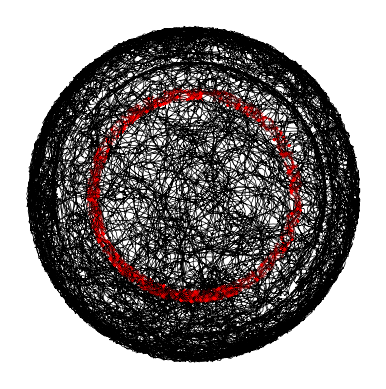

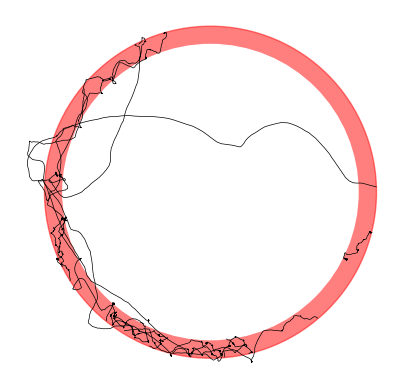

Fraction of hit and run encounters: 0.000000


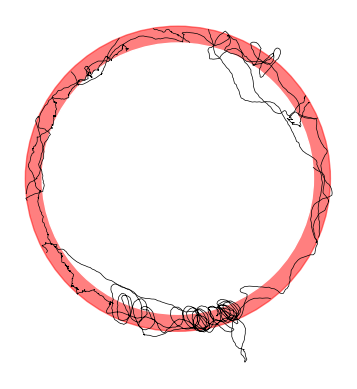

Fraction of hit and run encounters: 0.000000


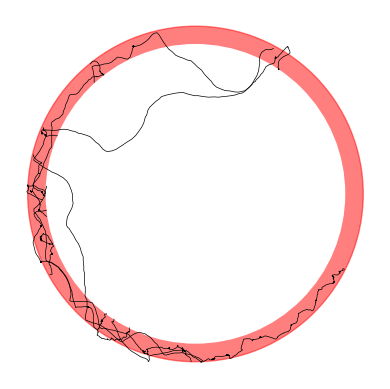

Fraction of hit and run encounters: 0.000000


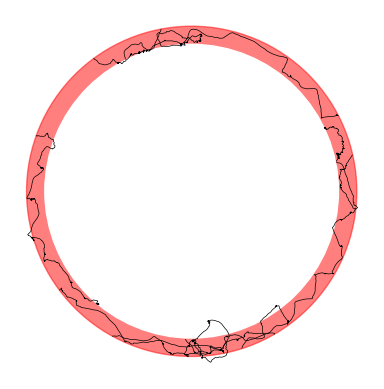

Fraction of hit and run encounters: 0.300000


In [12]:
# load csv
filename = '-ablated-l'

fractions = []

# load csv
df = pd.read_csv('tracks' + filename + '.csv')

# Compute the convex hull of the points
points = df[['X', 'Y']].values
hull = ConvexHull(points)
hull_points = []
for simplex in hull.simplices:
    hull_points.append(points[simplex, :])
hull_points = np.concatenate(hull_points)
# get the center of the circle
radius, center = sphere_fit(hull_points)

f = h5py.File('data' + filename + '.h5', 'r')
data = f['data']
n_flies = data[:].shape[1]

# get first frame and last frame with phase == stim
start_frames = []
end_frames = []
for i in range(n_flies):
    fly = data[10:,i]
    phase = fly['phase']
    start_frames.append(np.where(phase == b'stim')[0][0])
    end_frames.append(np.where(phase == b'stim')[0][-1])
start_frame = int(np.min(start_frames))
end_frame = int(np.max(end_frames))

points = []
for i in range(n_flies):
    fly = data[10:,i]
    x = fly['position_x']
    y = fly['position_y']
    odor = fly['red_at_position']
    # get only x position and y position where odor is present
    x_odor = x[odor>0]
    y_odor = y[odor>0]
    points.append(np.array([x_odor, y_odor]).T)
points = np.concatenate(points)
# Compute the convex hull of the points
hull = ConvexHull(points)
# Plot the convex hull
hull_points = []
for simplex in hull.simplices:
    hull_points.append(points[simplex, :])
hull_points = np.concatenate(hull_points)
# get the center of the circle
outer_radius, trail_center_outer = sphere_fit(hull_points)

# get all points that are within the bounds and right after odor
points = []
for i in range(n_flies):
    fly = data[10:,i]
    x = fly['position_x']
    y = fly['position_y']
    odor = fly['red_at_position']
    r = np.sqrt((x-trail_center_outer[0])**2 + (y-trail_center_outer[1])**2)
    within_radius = r < outer_radius-10
    # get only x position and y position where odor is present
    x_odor = x[1:][np.logical_and(np.diff(odor)<0, within_radius[1:])]
    y_odor = y[1:][np.logical_and(np.diff(odor)<0, within_radius[1:])]
    points.append(np.array([x_odor, y_odor]).T)
# get the convex hull of the points
points = np.concatenate(points)
hull = ConvexHull(points)
hull_points = []
for simplex in hull.simplices:
    hull_points.append(points[simplex, :])
hull_points = np.concatenate(hull_points)
# get the center of the circle
inner_radius, trail_center_inner = sphere_fit(hull_points)

# get radial distance from trail_center_inner
df['r_inner'] = np.sqrt((df['X']-trail_center_inner[0])**2 + (df['Y']-trail_center_inner[1])**2)
df['r_outer'] = np.sqrt((df['X']-trail_center_outer[0])**2 + (df['Y']-trail_center_outer[1])**2)

# transform the points to the real coordinate system
df['X'] = (df['X'] - center[0])/radius*arena_radius
df['Y'] = (df['Y'] - center[1])/radius*arena_radius
# get radial distance from center
df['r'] = np.sqrt(df['X']**2 + df['Y']**2)
# get the points that are within the bounds
df['outside'] = df['r_outer'] > outer_radius
df['inside'] = df['r_inner'] < inner_radius
df['in_trail_region'] = np.logical_not(np.logical_or(df['outside'], df['inside']))

df['during_stim'] = np.logical_and(df['FrameID'] > start_frame, df['FrameID'] < end_frame)

df['in_odor'] = df['in_trail_region'] & df['during_stim']

# plot the trajectories with the odor trail
fig, ax = plt.subplots()
for fly_id in df['TargetID'].unique():
    fly = df[df['TargetID'] == fly_id]
    ax.plot(fly['X'], fly['Y'],'-',color='black',linewidth=0.5,zorder=1)
    ax.scatter(fly['X'][fly['in_odor']], fly['Y'][fly['in_odor']],color='red',s=0.01)
    
ax.set_aspect('equal')
ax.set_axis_off()

max_gap =  3*25

for fly_id in df['TargetID'].unique():
    fly = df[df['TargetID'] == fly_id]
    x = fly['X'].values
    y = fly['Y'].values
    inside = fly['inside'].values
    outside = fly['outside'].values
    odor = fly['in_odor'].values
    stim_on = fly['during_stim'].values

    segments = get_segments(fly['in_odor'], max_gap)

    # sort the segments by length
    segments = sorted(segments, key=lambda x: x[1] - x[0], reverse=True)

    # keep only the first 10 longest segments
    segments = segments[:10]
    


    # plot the segments
    fig, ax = plt.subplots()
    for start, end in segments:
        x = fly['X'][start:end + 1]*radius/arena_radius + center[0]
        y = fly['Y'][start:end + 1]*radius/arena_radius + center[1]
        ax.plot(x, y, '-', color='black', linewidth=0.5, zorder=1)
        # ax.scatter(fly['X'][start:end + 1][fly['in_odor'][start:end + 1]], fly['Y'][start:end + 1][fly['in_odor'][start:end + 1]], color='red', s=0.01)
    # draw the region of interest
    ax.add_patch(plt.Circle(trail_center_outer, outer_radius, color='red', alpha=0.5, zorder=-1))
    # draw the region of interest
    ax.add_patch(plt.Circle(trail_center_inner, inner_radius, color='white', alpha=1, zorder=0))
    ax.set_aspect('equal')
    ax.set_axis_off()
    plt.savefig('segments_%d.pdf' % fly_id, dpi=400)
    plt.show()

    # get whether segment is during stim
    during_stim = []
    for start, end in segments:
        during_stim.append(np.all(stim_on[start:end + 1]))
    during_stim = np.array(during_stim)


    # get number of entries in each segment
    n_entries = []
    for start, end in segments:
        odor_seg = odor[start:end + 1]
        n_entries.append(np.sum(np.diff(np.int32(odor_seg))==1)+1)
    n_entries = np.array(n_entries)

    # get whether the sides are the same
    same_side = []
    for start, end in segments:
        start = max(0, start - 1)
        end = min(len(fly) - 1, end + 1)
        start_inside = inside[start]
        end_inside = inside[end]
        start_outside = outside[start]
        end_outside = outside[end]
        same_side.append((start_inside == end_inside) or (start_outside == end_outside))
    same_side = np.array(same_side)

    # hit and run encounters are encounter with a single entry and same side exit
    hit_and_run = (n_entries == 1) & same_side & during_stim
    n_hit_and_run = np.sum(hit_and_run)
    n_during_stim = np.sum(during_stim)
    print("Fraction of hit and run encounters: %f" % (n_hit_and_run / n_during_stim))
    fractions.append(n_hit_and_run / n_during_stim)


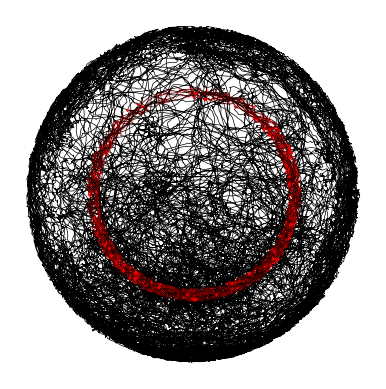

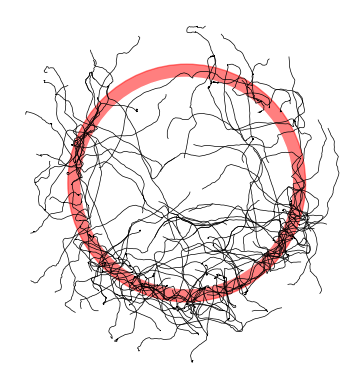

Fraction of hit and run encounters: 0.081395


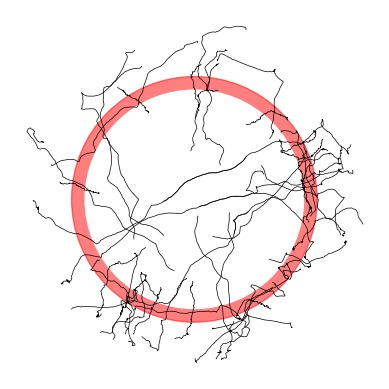

Fraction of hit and run encounters: 0.041667


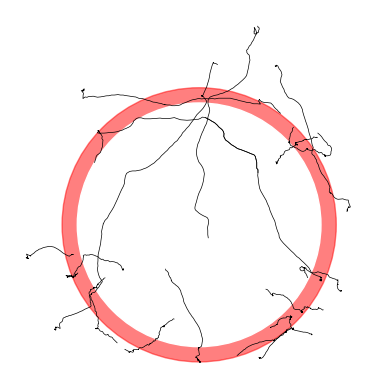

Fraction of hit and run encounters: 0.000000


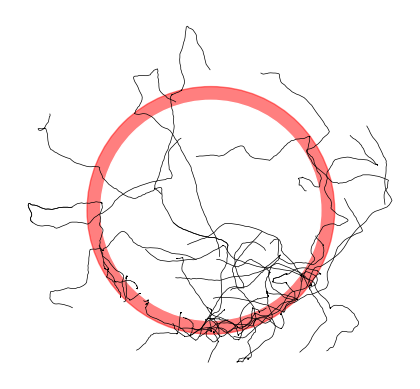

Fraction of hit and run encounters: 0.096774


In [51]:
# load csv
filename = '-starved-1'

fractions = []

# load csv
df = pd.read_csv('tracks' + filename + '.csv')

# Compute the convex hull of the points
points = df[['X', 'Y']].values
hull = ConvexHull(points)
hull_points = []
for simplex in hull.simplices:
    hull_points.append(points[simplex, :])
hull_points = np.concatenate(hull_points)
# get the center of the circle
radius, center = sphere_fit(hull_points)

f = h5py.File('data' + filename + '.h5', 'r')
data = f['data']
n_flies = data[:].shape[1]

# get first frame and last frame with phase == stim
start_frames = []
end_frames = []
for i in range(n_flies):
    fly = data[10:,i]
    phase = fly['phase']
    start_frames.append(np.where(phase == b'stim')[0][0])
    end_frames.append(np.where(phase == b'stim')[0][-1])
start_frame = int(np.min(start_frames))
end_frame = int(np.max(end_frames))

points = []
for i in range(n_flies):
    fly = data[10:,i]
    x = fly['position_x']
    y = fly['position_y']
    odor = fly['red_at_position']
    # get only x position and y position where odor is present
    x_odor = x[odor>0]
    y_odor = y[odor>0]
    points.append(np.array([x_odor, y_odor]).T)
points = np.concatenate(points)
# Compute the convex hull of the points
hull = ConvexHull(points)
# Plot the convex hull
hull_points = []
for simplex in hull.simplices:
    hull_points.append(points[simplex, :])
hull_points = np.concatenate(hull_points)
# get the center of the circle
outer_radius, trail_center_outer = sphere_fit(hull_points)

# get all points that are within the bounds and right after odor
points = []
for i in range(n_flies):
    fly = data[10:,i]
    x = fly['position_x']
    y = fly['position_y']
    odor = fly['red_at_position']
    r = np.sqrt((x-trail_center_outer[0])**2 + (y-trail_center_outer[1])**2)
    within_radius = r < outer_radius-10
    # get only x position and y position where odor is present
    x_odor = x[1:][np.logical_and(np.diff(odor)<0, within_radius[1:])]
    y_odor = y[1:][np.logical_and(np.diff(odor)<0, within_radius[1:])]
    points.append(np.array([x_odor, y_odor]).T)
# get the convex hull of the points
points = np.concatenate(points)
hull = ConvexHull(points)
hull_points = []
for simplex in hull.simplices:
    hull_points.append(points[simplex, :])
hull_points = np.concatenate(hull_points)
# get the center of the circle
inner_radius, trail_center_inner = sphere_fit(hull_points)

# get radial distance from trail_center_inner
df['r_inner'] = np.sqrt((df['X']-trail_center_inner[0])**2 + (df['Y']-trail_center_inner[1])**2)
df['r_outer'] = np.sqrt((df['X']-trail_center_outer[0])**2 + (df['Y']-trail_center_outer[1])**2)

# transform the points to the real coordinate system
df['X'] = (df['X'] - center[0])/radius*arena_radius
df['Y'] = (df['Y'] - center[1])/radius*arena_radius
# get radial distance from center
df['r'] = np.sqrt(df['X']**2 + df['Y']**2)
# get the points that are within the bounds
df['outside'] = df['r_outer'] > outer_radius
df['inside'] = df['r_inner'] < inner_radius
df['in_trail_region'] = np.logical_not(np.logical_or(df['outside'], df['inside']))

df['during_stim'] = np.logical_and(df['FrameID'] > start_frame, df['FrameID'] < end_frame)

df['in_odor'] = df['in_trail_region'] & df['during_stim']

# plot the trajectories with the odor trail
fig, ax = plt.subplots()
for fly_id in df['TargetID'].unique():
    fly = df[df['TargetID'] == fly_id]
    ax.plot(fly['X'], fly['Y'],'-',color='black',linewidth=0.5,zorder=1)
    ax.scatter(fly['X'][fly['in_odor']], fly['Y'][fly['in_odor']],color='red',s=0.01)
    
ax.set_aspect('equal')
ax.set_axis_off()

max_gap = 3*25
prevtime = 2*25
nexttime = 5*25

all_angular_velocity = []

for fly_id in df['TargetID'].unique():
    fly = df[df['TargetID'] == fly_id]
    x = fly['X'].values
    y = fly['Y'].values
    heading = np.unwrap(fly['Theta'].values)
    frames = fly['FrameID'].values
    angular_velocity = np.diff(heading)/np.diff(frames)
    angular_velocity = np.insert(angular_velocity, 0, 0)
    inside = fly['inside'].values
    outside = fly['outside'].values
    odor = fly['in_odor'].values
    stim_on = fly['during_stim'].values

    segments = get_segments(fly['in_odor'], max_gap)

    


    # plot the segments
    fig, ax = plt.subplots()
    for start, end in segments:
        start = max(0, start - prevtime)
        end = min(len(fly) - 1, start + nexttime)
        all_angular_velocity.append(angular_velocity[start:end + 1])

        x = fly['X'][start:end + 1]*radius/arena_radius + center[0]
        y = fly['Y'][start:end + 1]*radius/arena_radius + center[1]
        ax.plot(x, y, '-', color='black', linewidth=0.5, zorder=1)
        # ax.scatter(fly['X'][start:end + 1][fly['in_odor'][start:end + 1]], fly['Y'][start:end + 1][fly['in_odor'][start:end + 1]], color='red', s=0.01)
    # draw the region of interest
    ax.add_patch(plt.Circle(trail_center_outer, outer_radius, color='red', alpha=0.5, zorder=-1))
    # draw the region of interest
    ax.add_patch(plt.Circle(trail_center_inner, inner_radius, color='white', alpha=1, zorder=0))
    ax.set_aspect('equal')
    ax.set_axis_off()
    plt.savefig('segments_%d.pdf' % fly_id, dpi=400)
    plt.show()

    # get whether segment is during stim
    during_stim = []
    for start, end in segments:
        during_stim.append(np.all(stim_on[start:end + 1]))
    during_stim = np.array(during_stim)


    # get number of entries in each segment
    n_entries = []
    for start, end in segments:
        odor_seg = odor[start:end + 1]
        n_entries.append(np.sum(np.diff(np.int32(odor_seg))==1)+1)
    n_entries = np.array(n_entries)

    # get whether the sides are the same
    same_side = []
    for start, end in segments:
        start = max(0, start - 1)
        end = min(len(fly) - 1, end + 1)
        start_inside = inside[start]
        end_inside = inside[end]
        start_outside = outside[start]
        end_outside = outside[end]
        same_side.append((start_inside == end_inside) or (start_outside == end_outside))
    same_side = np.array(same_side)

    # hit and run encounters are encounter with a single entry and same side exit
    hit_and_run = (n_entries == 1) & same_side & during_stim
    n_hit_and_run = np.sum(hit_and_run)
    n_during_stim = np.sum(during_stim)
    print("Fraction of hit and run encounters: %f" % (n_hit_and_run / n_during_stim))
    fractions.append(n_hit_and_run / n_during_stim)


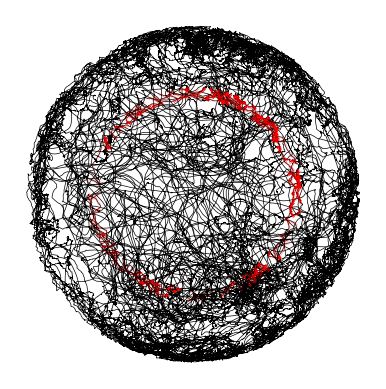

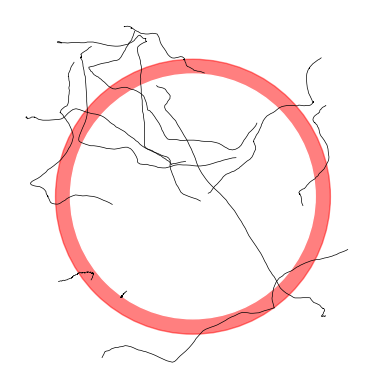

Fraction of hit and run encounters: 0.083333


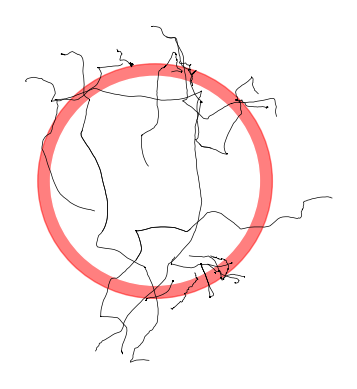

Fraction of hit and run encounters: 0.086957


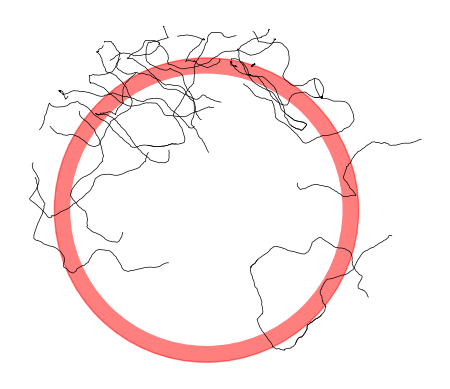

Fraction of hit and run encounters: 0.166667


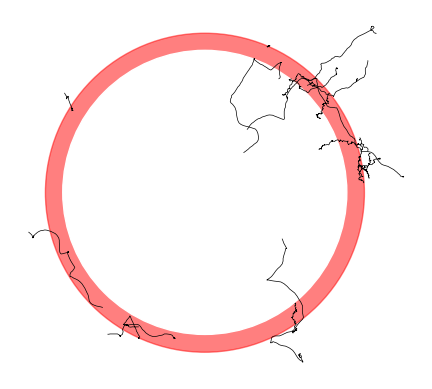

Fraction of hit and run encounters: 0.166667


In [52]:
# load csv
filename = '-starved-2'

fractions = []

# load csv
df = pd.read_csv('tracks' + filename + '.csv')

# Compute the convex hull of the points
points = df[['X', 'Y']].values
hull = ConvexHull(points)
hull_points = []
for simplex in hull.simplices:
    hull_points.append(points[simplex, :])
hull_points = np.concatenate(hull_points)
# get the center of the circle
radius, center = sphere_fit(hull_points)

f = h5py.File('data' + filename + '.h5', 'r')
data = f['data']
n_flies = data[:].shape[1]

# get first frame and last frame with phase == stim
start_frames = []
end_frames = []
for i in range(n_flies):
    fly = data[10:,i]
    phase = fly['phase']
    start_frames.append(np.where(phase == b'stim')[0][0])
    end_frames.append(np.where(phase == b'stim')[0][-1])
start_frame = int(np.min(start_frames))
end_frame = int(np.max(end_frames))

points = []
for i in range(n_flies):
    fly = data[10:,i]
    x = fly['position_x']
    y = fly['position_y']
    odor = fly['red_at_position']
    # get only x position and y position where odor is present
    x_odor = x[odor>0]
    y_odor = y[odor>0]
    points.append(np.array([x_odor, y_odor]).T)
points = np.concatenate(points)
# Compute the convex hull of the points
hull = ConvexHull(points)
# Plot the convex hull
hull_points = []
for simplex in hull.simplices:
    hull_points.append(points[simplex, :])
hull_points = np.concatenate(hull_points)
# get the center of the circle
outer_radius, trail_center_outer = sphere_fit(hull_points)

# get all points that are within the bounds and right after odor
points = []
for i in range(n_flies):
    fly = data[10:,i]
    x = fly['position_x']
    y = fly['position_y']
    odor = fly['red_at_position']
    r = np.sqrt((x-trail_center_outer[0])**2 + (y-trail_center_outer[1])**2)
    within_radius = r < outer_radius-10
    # get only x position and y position where odor is present
    x_odor = x[1:][np.logical_and(np.diff(odor)<0, within_radius[1:])]
    y_odor = y[1:][np.logical_and(np.diff(odor)<0, within_radius[1:])]
    points.append(np.array([x_odor, y_odor]).T)
# get the convex hull of the points
points = np.concatenate(points)
hull = ConvexHull(points)
hull_points = []
for simplex in hull.simplices:
    hull_points.append(points[simplex, :])
hull_points = np.concatenate(hull_points)
# get the center of the circle
inner_radius, trail_center_inner = sphere_fit(hull_points)

# get radial distance from trail_center_inner
df['r_inner'] = np.sqrt((df['X']-trail_center_inner[0])**2 + (df['Y']-trail_center_inner[1])**2)
df['r_outer'] = np.sqrt((df['X']-trail_center_outer[0])**2 + (df['Y']-trail_center_outer[1])**2)

# transform the points to the real coordinate system
df['X'] = (df['X'] - center[0])/radius*arena_radius
df['Y'] = (df['Y'] - center[1])/radius*arena_radius
# get radial distance from center
df['r'] = np.sqrt(df['X']**2 + df['Y']**2)
# get the points that are within the bounds
df['outside'] = df['r_outer'] > outer_radius
df['inside'] = df['r_inner'] < inner_radius
df['in_trail_region'] = np.logical_not(np.logical_or(df['outside'], df['inside']))

df['during_stim'] = np.logical_and(df['FrameID'] > start_frame, df['FrameID'] < end_frame)

df['in_odor'] = df['in_trail_region'] & df['during_stim']

# plot the trajectories with the odor trail
fig, ax = plt.subplots()
for fly_id in df['TargetID'].unique():
    fly = df[df['TargetID'] == fly_id]
    ax.plot(fly['X'], fly['Y'],'-',color='black',linewidth=0.5,zorder=1)
    ax.scatter(fly['X'][fly['in_odor']], fly['Y'][fly['in_odor']],color='red',s=0.01)
    
ax.set_aspect('equal')
ax.set_axis_off()

max_gap = 3*25
prevtime = 2*25
nexttime = 5*25

all_angular_velocity = []

for fly_id in df['TargetID'].unique():
    fly = df[df['TargetID'] == fly_id]
    x = fly['X'].values
    y = fly['Y'].values
    heading = np.unwrap(fly['Theta'].values)
    frames = fly['FrameID'].values
    angular_velocity = np.diff(heading)/np.diff(frames)
    angular_velocity = np.insert(angular_velocity, 0, 0)
    inside = fly['inside'].values
    outside = fly['outside'].values
    odor = fly['in_odor'].values
    stim_on = fly['during_stim'].values

    segments = get_segments(fly['in_odor'], max_gap)

    


    # plot the segments
    fig, ax = plt.subplots()
    for start, end in segments:
        start = max(0, start - prevtime)
        end = min(len(fly) - 1, start + nexttime)
        all_angular_velocity.append(angular_velocity[start:end + 1])

        x = fly['X'][start:end + 1]*radius/arena_radius + center[0]
        y = fly['Y'][start:end + 1]*radius/arena_radius + center[1]
        ax.plot(x, y, '-', color='black', linewidth=0.5, zorder=1)
        # ax.scatter(fly['X'][start:end + 1][fly['in_odor'][start:end + 1]], fly['Y'][start:end + 1][fly['in_odor'][start:end + 1]], color='red', s=0.01)
    # draw the region of interest
    ax.add_patch(plt.Circle(trail_center_outer, outer_radius, color='red', alpha=0.5, zorder=-1))
    # draw the region of interest
    ax.add_patch(plt.Circle(trail_center_inner, inner_radius, color='white', alpha=1, zorder=0))
    ax.set_aspect('equal')
    ax.set_axis_off()
    plt.savefig('segments_%d.pdf' % fly_id, dpi=400)
    plt.show()

    # get whether segment is during stim
    during_stim = []
    for start, end in segments:
        during_stim.append(np.all(stim_on[start:end + 1]))
    during_stim = np.array(during_stim)


    # get number of entries in each segment
    n_entries = []
    for start, end in segments:
        odor_seg = odor[start:end + 1]
        n_entries.append(np.sum(np.diff(np.int32(odor_seg))==1)+1)
    n_entries = np.array(n_entries)

    # get whether the sides are the same
    same_side = []
    for start, end in segments:
        start = max(0, start - 1)
        end = min(len(fly) - 1, end + 1)
        start_inside = inside[start]
        end_inside = inside[end]
        start_outside = outside[start]
        end_outside = outside[end]
        same_side.append((start_inside == end_inside) or (start_outside == end_outside))
    same_side = np.array(same_side)

    # hit and run encounters are encounter with a single entry and same side exit
    hit_and_run = (n_entries == 1) & same_side & during_stim
    n_hit_and_run = np.sum(hit_and_run)
    n_during_stim = np.sum(during_stim)
    print("Fraction of hit and run encounters: %f" % (n_hit_and_run / n_during_stim))
    fractions.append(n_hit_and_run / n_during_stim)


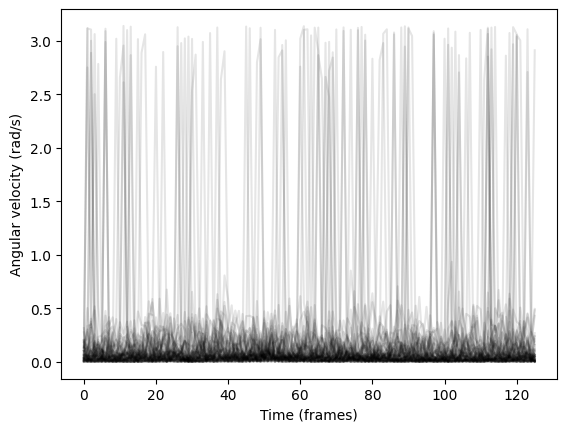

In [53]:
angular_velocity = np.abs(np.array(all_angular_velocity))
# plot the angular velocity
fig, ax = plt.subplots()
ax.plot(angular_velocity.T, color='black', alpha=0.1)
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Angular velocity (rad/s)')
plt.show()

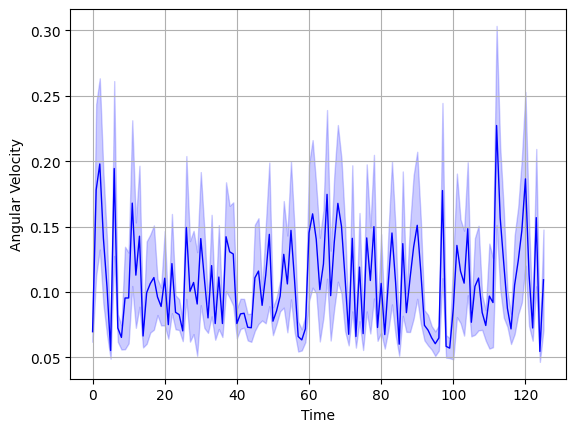

In [54]:
plt.plot(np.abs(angular_velocity).mean(axis=0), color='blue', linewidth=1)
# plot the standard error = mean +/- std/sqrt(n)
plt.fill_between(np.arange(angular_velocity.shape[1]), np.abs(angular_velocity).mean(axis=0) - np.abs(angular_velocity).std(axis=0)/np.sqrt(angular_velocity.shape[0]), np.abs(angular_velocity).mean(axis=0) + np.abs(angular_velocity).std(axis=0)/np.sqrt(angular_velocity.shape[0]), color='blue', alpha=0.2)
plt.xlabel('Time')
plt.ylabel('Angular Velocity')
plt.grid()

In [ ]:
angular_velocity.

array([[ 1.88077450e-01,  3.28683376e-01, -6.05999231e-02, ...,
        -6.00295152e-02, -3.14900918e+00, -6.42116070e-02],
       [-1.92880333e-02, -7.01802164e-01, -3.72318217e+00, ...,
        -2.56289082e-01, -6.32677555e-01, -5.61582446e-01],
       [-3.27733930e-02, -9.14316465e-03, -1.46045091e-02, ...,
        -1.56734496e-01,  6.11414409e+00, -6.21739618e+00],
       ...,
       [ 5.05635738e-02, -3.40182900e-01, -3.54692191e-01, ...,
         9.72097159e-03, -6.04776789e+00,  2.24898770e-01],
       [-1.20908845e-02,  9.17152732e-03,  7.31037719e-05, ...,
        -6.99080825e-02, -5.37235737e-02, -7.31575489e-02],
       [ 7.39061832e-02,  1.96728110e-02,  9.04123783e-02, ...,
         1.14837646e-01, -4.43987548e-02, -4.90618199e-02]])

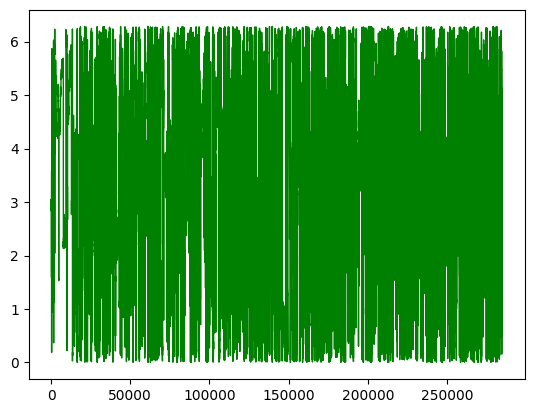

In [47]:
plt.plot(fly['Theta'], color='green', linewidth=1)